# Co-training

**Autori:** Peter Macinec, Lukas Janik, Vajk Pomichal, Frantisek Sefcik

## Zakladne nastavenia a import kniznic

In [65]:
import pandas as pd
import numpy as np


# plots
import matplotlib.pyplot as plt
import seaborn as sns

import json

import re

import nltk
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection as ms

from sklearn.metrics import confusion_matrix

import statistics

from functools import reduce

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'

### Nacitanie datasetu

Nase data su dostupne v dvoch suboroch, *train.tsv* a *test.tsv*. Nacitame ich oba a vykoname na nich zakladnu analyzu. Zdroj: https://www.kaggle.com/c/stumbleupon

In [66]:
# trenovacie data
df = pd.read_csv('data/train.tsv', sep='\t')

In [67]:
# testovacie data
df_t = pd.read_csv('data/test.tsv', sep='\t')

## Textove atributy

Najskor predspracujeme text. Ziskame ho z atributu boilerplate:

In [68]:
df['body_content'] = df['boilerplate'].apply(lambda x: json.loads(x)['body'])

Teraz odstranime vsetky znaky, ktore nie su znaky slov. Pouzijeme na to regularne vyrazy:

In [69]:
df['body_content'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [70]:
df['body_content'] = df['body_content'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', str(x)))

Este ako male upravy, aby nas slovnik obsahoval kazde slovo len raz, dame ich vsetky na lowercase a rozdelime texty na slova, aby sme ich nasledne mohli spracovat:

In [71]:
df['body_content'] = df['body_content'].apply(lambda x: str(x).lower().split())

Teraz potrebujeme este odstranit slova, ktore nedavaju vyznam. O jednom raze prevedieme slova na ich korenovy zaklad pouzitim stemmingu:

In [72]:
porter_stemmer = PorterStemmer()
stopwords = set(stopwords.words('english'))

In [73]:
df['body_content'] = df['body_content'].apply(lambda x: [porter_stemmer.stem(word) for word in x if word not in stopwords])

Teraz uz mame vsetky slova pripravene, uz ich len naspat spojime do jednej suvislej vety, aby s nimi vedeli lahsie pracovat algoritmy spracovania textu:

In [74]:
df['body_content_final'] = df['body_content'].apply(lambda x: ' '.join(x))

### TF-IDF

In [75]:
tv = TfidfVectorizer(max_features = 1000)
tf_idf = tv.fit_transform(df['body_content_final']).toarray()

### Atribut URL

In [76]:
df['url_new'] = df['url'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', str(x)))
df['url_new'] = df['url_new'].apply(lambda x: str(x).lower().split())

In [77]:
df['url_new'] = df['url_new'].apply(lambda x: [porter_stemmer.stem(word) for word in x if word not in stopwords])

In [78]:
df['url_final'] = df['url_new'].apply(lambda x: ' '.join(x))

In [79]:
tv_url = TfidfVectorizer(max_features = 1000)
tf_idf_url = tv_url.fit_transform(df['url_final']).toarray()

## Numericke atributy

In [80]:
num_feature_set = ['avglinksize', 'commonlinkratio_1', 'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
                   'hasDomainLink','lengthyLinkDomain','linkwordscore','numberOfLinks',
                   'numwords_in_url', 'parametrizedLinkRatio']

## Benchmark model

Natrenujeme benchmarkovy model, ktory bude natrenovany na vsetkych atributoch. Jeho vysledky sa nasledne budeme snazit dosiahnut s minimom oznacenych dat s co-trainingom.

In [81]:
y = df.label

In [82]:
df1 = df.loc[:, num_feature_set]

In [83]:
df2 = pd.DataFrame(tf_idf_url)

In [84]:
X_temp = pd.concat([df2, pd.DataFrame(tf_idf)], axis=1, join_axes=[df2.index])
X_temp.columns = list(range(0,2000))

In [85]:
X = pd.concat([df1, X_temp], axis=1, join_axes=[df1.index])

In [86]:
X.head()

,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,hasDomainLink,lengthyLinkDomain,linkwordscore,numberOfLinks,numwords_in_url,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,2.055556,0.676471,0.205882,0.047059,0.023529,0,1,24,170,8,...,0.0,0.00000,0.157927,0.0,0.000000,0.028198,0.0,0.0,0.064583,0.0
1,3.677966,0.508021,0.288770,0.213904,0.144385,0,1,40,187,9,...,0.0,0.00000,0.031715,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,2.382883,0.562016,0.321705,0.120155,0.042636,0,1,55,258,11,...,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,1.543103,0.400000,0.100000,0.016667,0.000000,0,0,24,120,5,...,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,2.676471,0.500000,0.222222,0.123457,0.043210,0,1,14,162,10,...,0.0,0.02762,0.107720,0.0,0.129191,0.128223,0.0,0.0,0.088102,0.0


In [87]:
col_names1 = list(range(0,1000))
col_names1 = num_feature_set + col_names1
col_names2 = list(range(1000,2000))
# col_names2 = [str(i) for i in col_names2]

In [88]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
benchmark_clf = RandomForestClassifier(n_estimators=500, max_depth=20,
                              random_state=10)

In [90]:
benchmark_clf.fit(X_train, y_train)
y_pred = benchmark_clf.predict(X_test)

In [91]:
confusion_matrix(y_test, y_pred)

array([[656,  74],
       [221, 528]], dtype=int64)

In [92]:
accuracy_score(y_test, y_pred)

0.8005409060175794

## Co-training evaluation

In [106]:
class CombinedClassifier:
    
    def __init__(self,clf1, clf2, cols1, cols2):
        self.clf1 = clf1
        self.clf2 = clf2
        self.cols1 = cols1
        self.cols2 = cols2
        
    def predict(self, df):
        result = []
        for ind, row in df.iterrows():
            
            prob0 = self.clf1.predict_proba([df.loc[ind,self.cols1]])[0][0] * self.clf2.predict_proba([df.loc[ind,self.cols2]])[0][0]  
            prob1 = self.clf1.predict_proba([df.loc[ind,self.cols1]])[0][1] * self.clf2.predict_proba([df.loc[ind,self.cols2]])[0][1]
            res = 0 if prob0 > prob1 else 1
            result.append(res)
        return result

### Co-training with iterations

In [107]:
def co_training(L, U, col_names1, col_names2, clf1, clf2,u=75, k=30,p=1,n=3, label='label', X_test=None, y_test=None, random_state=None):
    '''
    L - labeled data
    U - unlabeled data
    col_names1 - columns for clf1
    col_names2 - columns for clf2
    clf1 - classificator1
    clf2 - classificator2
    u - number of unlabeled data for training
    k - number of iteration
    p - number of positive examles to add label per iteration
    n - number of negative examles to add label per iteration
    label - name of column in L whit label
    '''
    
#     U0 = U.sample(u, random_state= random_state)
#     U.drop(U0.index, inplace=True)
    k0 = k
    pred_1 = []
    pred_2 = []
    while k > 0:
        #print("iteration: ", k0 - k)
        # step 1: Use L to train a classifier h1 that considers only the x1 portion of x
        clf1 = clf1.fit(L[col_names1],  L[label])
        
        # step 2: Use L, to train a classifier h2 that considers only the x2 portion of x
        clf2 = clf2.fit(L[col_names2], L[label])
        
        # step 3: Allow hl to label p positive and n negative examples from U
        predicted_prob1 = clf1.predict_proba(U[col_names1])
        top_positive1 = predicted_prob1[:,1].argsort()[-p:]
        top_negative1 = predicted_prob1[:,0].argsort()[-n:]
        
        # step 4: Allow hl to label p positive and n negative examples from U
        predicted_prob2 = clf2.predict_proba(U[col_names2])
        top_positive2 = predicted_prob2[:,1].argsort()[-p:]
        top_negative2 = predicted_prob2[:,0].argsort()[-n:]    
        
        # step 5: Add these self-labeled examples to L
        positive_ind = U.iloc[np.unique(np.concatenate((top_positive1,top_positive2))),:].index
        negative_ind = U.iloc[np.unique(np.concatenate((top_negative1,top_negative2))),:].index
        self_labeled = U.loc[np.unique(np.concatenate((positive_ind,negative_ind))),:]
        U.drop(self_labeled.index, inplace=True)
        self_labeled.loc[positive_ind, label] = 1
        self_labeled.loc[negative_ind, label] = 0
        L = pd.concat([L, self_labeled])
    
        if (X_test is not None and y_test is not None):
            pred = clf1.predict(X_test[col_names1])
            pred_1.append(accuracy_score(y_test,pred))
            
            pred = clf2.predict(X_test[col_names2])
            pred_2.append(accuracy_score(y_test,pred))

        k -= 1
    
    return [clf1, clf2, pred_1, pred_2]

In [108]:
col_names1 = list(range(0,1000))
col_names1 = num_feature_set + col_names1
col_names2 = list(range(1000,2000))

In [109]:
scores = [[0 for _ in range(3)] for _ in range(2)]

for x in range(2):
    df_x0 = X_train[y_train == 0].sample(5)
    df_x1 = X_train[y_train == 1].sample(5)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression()
    clf2 = LogisticRegression()

    new_1, new_2, scores[x][0], scores[x][1] = co_training(L=train,U=x_train, 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, k=30, n=2, p=2, X_test=X_test, y_test=y_test)
    
#     pred = new_1.predict(X_test[col_names1])
#     scores[0].append(accuracy_score(y_test, pred))

#     pred = new_2.predict(X_test[col_names2])
#     scores[1].append(accuracy_score(y_test, pred))

    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores[x][2] = accuracy_score(y_test, pred)

In [119]:
avg_accuracy1 = []
avg_accuracy2 = []
model_accuracy1 = []
model_accuracy2 = []
for i in range(30):
    sum_1 = 0 
    sum_2 = 0
    for j in range(2):
        sum_1 += scores[j][0][i]
        sum_2 += scores[j][1][i]
        if i == 29:
            model_accuracy1.append(scores[j][0][i])
            model_accuracy2.append(scores[j][1][i])
    avg_accuracy1.append(sum_1 / 2)
    avg_accuracy2.append(sum_2 / 2)

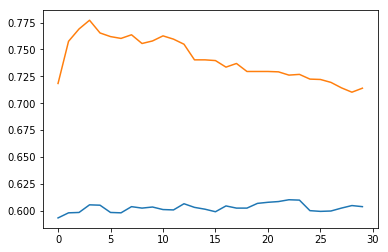

In [118]:
plt.plot(avg_accuracy1)
plt.plot(avg_accuracy2)

In [124]:
print("Min: " + str(np.min(model_accuracy1)))
print("Max: " + str(np.max(model_accuracy1)))
print("Avg: " + str(np.mean(model_accuracy1)))
print("Std: " + str(np.std(model_accuracy1)))

Min: 0.5868830290736985
Max: 0.6206896551724138
Avg: 0.6037863421230562
Std: 0.01690331304935766


In [125]:
print("Min: " + str(np.min(model_accuracy2)))
print("Max: " + str(np.max(model_accuracy2)))
print("Avg: " + str(np.mean(model_accuracy2)))
print("Std: " + str(np.std(model_accuracy2)))

Min: 0.6991210277214334
Max: 0.7288708586883029
Avg: 0.7139959432048681
Std: 0.01487491548343478


In [126]:
score_combined = []

for i in range(2):
    score_combined.append(scores[i][2])

print("Min: " + str(np.min(score_combined)))
print("Max: " + str(np.max(score_combined)))
print("Avg: " + str(np.mean(score_combined)))
print("Std: " + str(np.std(score_combined)))

Min: 0.6173089925625422
Max: 0.6747802569303584
Avg: 0.6460446247464503
Std: 0.028735632183908066


### Co-training with threshold

In [127]:
def co_training_threshold(L, U, col_names1, col_names2, clf1, clf2, label='label', random_state=None, X_test=None, y_test=None, threshold=0.8):
    '''
    L - labeled data
    U - unlabeled data
    col_names1 - columns for clf1
    col_names2 - columns for clf2
    clf1 - classificator1
    clf2 - classificator2
    label - name of column in L whit label
    threshold - threshold of predictions probability
    '''
    
    pred_1 = []
    pred_2 = []
    while len(U) > 0:
        
        # step 1: Use L to train a classifier h1 that considers only the x1 portion of x
        clf1 = clf1.fit(L[col_names1],  L[label])
        
        # step 2: Use L, to train a classifier h2 that considers only the x2 portion of x
        clf2 = clf2.fit(L[col_names2], L[label])
        
        # step 3: Allow hl to label p positive and n negative examples from U
        predicted_prob1 = clf1.predict_proba(U[col_names1])
        top_positive1 = predicted_prob1[:,1].argsort()[-1:] if predicted_prob1[:,1].argsort()[-1:] > threshold else [] 
        top_negative1 = predicted_prob1[:,0].argsort()[-1:] if predicted_prob1[:,0].argsort()[-1:] > threshold else []
        
        # step 4: Allow hl to label p positive and n negative examples from U
        predicted_prob2 = clf2.predict_proba(U[col_names2]) 
        top_positive2 = predicted_prob2[:,1].argsort()[-1:] if predicted_prob2[:,1].argsort()[-1:] > threshold else []
        top_negative2 = predicted_prob2[:,0].argsort()[-1:] if predicted_prob2[:,0].argsort()[-1:] > threshold else []
        
        # step 5: Add these self-labeled examples to L
        if(np.unique(np.concatenate((top_positive1,top_positive2, top_negative1, top_negative2))).size == 0):
            return [clf1,clf2]
        positive_ind = U.iloc[np.unique(np.concatenate((top_positive1,top_positive2))),:].index
        negative_ind = U.iloc[np.unique(np.concatenate((top_negative1,top_negative2))),:].index
        self_labeled = U.loc[np.unique(np.concatenate((positive_ind,negative_ind))),:]
        U.drop(self_labeled.index, inplace=True)
        self_labeled.loc[positive_ind, label] = 1
        self_labeled.loc[negative_ind, label] = 0
        L = pd.concat([L, self_labeled])
        
        if (X_test is not None and y_test is not None):
            pred = clf1.predict(X_test[col_names1])
            pred_1.append(accuracy_score(y_test,pred))
            
            pred = clf2.predict(X_test[col_names2])
            pred_2.append(accuracy_score(y_test,pred))
    
    return [clf1, clf2, pred_1, pred_2]

In [129]:
scores_threshold = [[0 for _ in range(3)] for _ in range(2)]

for x in range(2):
    df_x0 = X_train[y_train == 0].sample(5)
    df_x1 = X_train[y_train == 1].sample(5)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression()
    clf2 = LogisticRegression()

    new_1, new_2, scores[x][0], scores[x][1] = co_training_threshold(L=train,U=x_train, 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, X_test=X_test, y_test=y_test, threshold=0.8)
    
#     pred = new_1.predict(X_test[col_names1])
#     scores[0].append(accuracy_score(y_test, pred))

#     pred = new_2.predict(X_test[col_names2])
#     scores[1].append(accuracy_score(y_test, pred))

    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores_threshold[x][2] = accuracy_score(y_test, pred)

KeyboardInterrupt: 

In [ ]:
avg_accuracy1 = []
avg_accuracy2 = []
model_accuracy1 = []
model_accuracy2 = []
for i in range(30):
    sum_1 = 0 
    sum_2 = 0
    for j in range(2):
        sum_1 += scores_threshold[j][0][i]
        sum_2 += scores_threshold[j][1][i]
        if i == 29:
            model_accuracy1.append(scores_threshold[j][0][i])
            model_accuracy2.append(scores_threshold[j][1][i])
    avg_accuracy1.append(sum_1 / 2)
    avg_accuracy2.append(sum_2 / 2)

In [ ]:
plt.plot(avg_accuracy1)
plt.plot(avg_accuracy2)

In [ ]:
print("Min: " + str(np.min(model_accuracy1)))
print("Max: " + str(np.max(model_accuracy1)))
print("Avg: " + str(np.mean(model_accuracy1)))
print("Std: " + str(np.std(model_accuracy1)))

In [ ]:
print("Min: " + str(np.min(model_accuracy2)))
print("Max: " + str(np.max(model_accuracy2)))
print("Avg: " + str(np.mean(model_accuracy2)))
print("Std: " + str(np.std(model_accuracy2)))

In [ ]:
score_combined = []

for i in range(2):
    score_combined.append(scores_threshold[i][2])

print("Min: " + str(np.min(score_combined)))
print("Max: " + str(np.max(score_combined)))
print("Avg: " + str(np.mean(score_combined)))
print("Std: " + str(np.std(score_combined)))

### Self-training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

import classifiers
from classifiers import CoTrainingClassifier

In [ ]:
# df_x0 = X_train[y_train == 0].sample(5)
# df_x1 = X_train[y_train == 1].sample(5)

In [ ]:
# train = pd.concat([df_x0,df_x1])
# X_train.drop(train.index, inplace=True)
# train['label'] = y_train.loc[train.index]

In [ ]:
tmp1 = set(y_train[y_train == 0].sample(5).index) | set(y_train[y_train == 1].sample(5).index)
tmp2 = set(y_train.index) - set(tmp1)
y_train.loc[tmp2] = -1

In [ ]:
X_train.head()

In [66]:
y_train[y_train != -1].index

Int64Index([7227, 180, 1377, 1836, 2066, 4897, 5355, 938, 1059, 1585], dtype='int64')

In [68]:
lg_co_clf = CoTrainingClassifier(LogisticRegression(), p=2, n=2)
lg_co_clf.fit(X_train[col_names1].reset_index(), X_train[col_names2].reset_index(), y_train.reset_index())
y_pred = lg_co_clf.predict(X_test[col_names1], X_test[col_names2])
print (classification_report(y_test, y_pred))

In [ ]:
def run_co_training(df, cols1, cols2, label, clf1, clf2, p=5, n=5, p_class=1, n_class=0):

    #toto tu zbytocne rozbijam a spajam, na vstupe mozno lepsie dat series a to do dataframe
    df1 = df[[cols1]]
    df2 = df[[cols2]]
    y= df[label]
    
    X = pd.concat([df1, df2], axis=1, join_axes=[df1.index])
    X.columns = list(range(0,len(X)))

    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

    df_x0 = X_train[y_train == n_class].sample(n)

    df_x1 = X_train[y_train == p_class].sample(p)

    train = pd.concat([df_x0,df_x1])

    X_train.drop(train.index, inplace=True)

    train['label'] = y_train.loc[train.index]
    
    
    new_1, new_2 = co_training(L=train,U=X_train, 
                           col_names1=col_names1,
                           col_names2=col_names2, clf1=clf1, clf2=clf2, k=30, p=2,n=2)
    
    # accuracy z new1 a new2 (mozno aj zo spojeneho) trebu ulozit do pola a ten return